## Calculating equilibrium climate sensitivity

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Data catalogs

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

In [4]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing.

In [5]:
df['experiment_id'].unique()

array(['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc', '1pctCO2',
       'abrupt-4xCO2', 'historical', 'piControl', 'amip', 'esm-hist',
       'esm-piControl', 'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
       'dcppA-hindcast', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 'dcppC-hindcast-noPinatubo',
       'highresSST-present', 'control-1950', 'hist-1950',
       'deforest-globe', 'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
       'ssp245', 'ssp585'], dtype=object)

# Analysis of Climate Model Output Data

#### A simple helper function for regridding our data

In [6]:
# Define the common target grid axes
dlon, dlat = 1., 1.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.+dlat/2., 90., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

# Regridding function
def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [7]:
cat = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `historical` forcing experiment
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [26]:
# convert data catalog into a dictionary of xarray datasets
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
gmst_dict = {}
for name, ds in tqdm(dset_dict.items()):
    model_name = name.split(".")[2]
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    
    # regrid to common grid
    ds_new = regrid_to_common(ds['tas'], ds_out)  # regrid from native model grid to a common grid, facilitating comparisons between models
    ds_new.attrs.update(ds.attrs) # update regridded dataset 
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon','time']:
            ds_new = ds_new.drop(coord)

    Rearth = 6.378E6 # radius of Earth in meters (for estimating area of each grid cell)
    
    # a DataArray that gives grid cell areas on the lat/lon grid (in units of m^2)
    ds_new['area'] = (
        (np.deg2rad(dlat)*Rearth) * # latitudinal width of grid cell (in units of m)
        (np.deg2rad(dlon)*Rearth*np.cos(np.deg2rad(ds_new['lat'])) *  # longitudinal width of grid cell (in units of m)
         xr.ones_like(ds_new['lon'])) # broadcast longitudinal dimensions to give total dimensions of (lat, lon)
    )
    
    ## Calculate global-mean surface temperature (GMST)
    gmst = (ds_new*ds_new['area']).mean(dim=['lat','lon']) / ds_new['area'].mean(dim=['lat','lon']) # area-weighted average over (lat, lon) dimensions 
    
    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds_new

Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_129x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_256x512_180x360_peri.nc
Reuse existing file: bilinear_256x512_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_256x512_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_324x432_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_96x

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_80x96_180x360_peri.nc
Reuse existing file: bilinear_80x96_180x360_peri.nc



In [28]:
ctrl_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_dict[model_name] = ds
    
abrupt_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_dict.keys()): continue # keep only SSP simulations
    abrupt_dict[model_name] = ds

In [29]:
ctrl_gmst_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_gmst_dict[model_name] = gmst
    
abrupt_gmst_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_gmst_dict.keys()): continue # keep only SSP simulations
    abrupt_gmst_dict[model_name] = gmst

#### Example `xarray.DataArray`

The following is an example of an xarray.DataArray for the near-surface air temperature (`tas`) output from the MCM-UA climate model.

The dimensions `(member_id: 1, time: 1980, lat: 180, lon: 360)` signify that the 165 years of output is discretized into 1980 monthly-averages on a globe discretized into 180 1-degree latitdue bins and 360 longitude bins. The attributes of the DataArray describes various relevant metadata, such as a url for more info about the model, a reference publication which describes the simulation in detail, and the name of the model.


In [31]:
for name, ds in ctrl_dict.items():
    if model in name: ctrl_ds = ctrl_dict[name]
    
for name, ds in abrupt_dict.items():
    if model in name: abrupt_ds = abrupt_dict[name]
    

#### Visualizing warming patterns from 1890-1910 to 1990-2010

In [32]:
temperature_change = (
    abrupt_ds.isel(time=np.arange(-600,0)).mean(dim='time') -
    ctrl_ds.isel(time=np.arange(-600,0)).mean(dim='time')
).compute()
temperature_change.attrs.update(ds_new.attrs)
temperature_change = temperature_change.rename(
    r'temperature change ($^{\circ}$C) from 1890-1910 to 1990-2010'
)

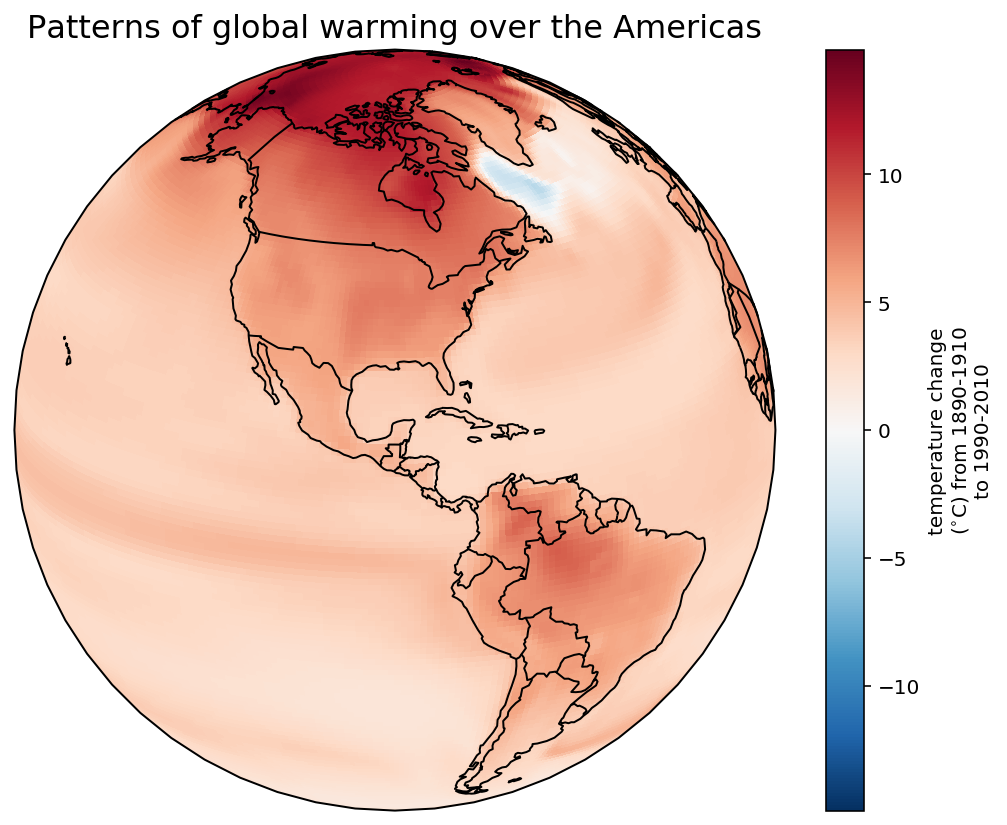

In [33]:
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(9,7))
ax = plt.subplot(1, 1, 1, projection=ortho)

q = temperature_change.plot(ax=ax, transform = geo) # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of global warming over the Americas',fontsize=16, ha='center');

#### Eagerly compute GMST for each model, in preparation for plotting

The operations we have done up to this point to calculate the global-mean surface temperature were evaluated lazily. In other worse, we have created a blueprint for how we want to evaluate the calculations, but have not yet computing them. This lets us do things like multiply two 1 Tb arrays together even though they are each individually larger-than-memory.

Now we call xarray's `compute()` method to carry out the computations we defined in the for loop above for calculation the global-mean surface temperature anomaly relative to the 1850-1900 mean.

In [ ]:
ECS_dict = {}
for name, gmst in tqdm(abrupt_gmst_dict.items()):
    gmst_change = (
        abrupt_gmst_dict[name].isel(time=np.arange(-600,0)).mean(dim='time') -
        ctrl_gmst_dict[name].isel(time=np.arange(-600,0)).mean(dim='time')
    ).compute()

    ECS_dict[name] = gmst_change/2.

In [ ]:
plt.hist(np.array(list(ECS_dict.values())))